In [27]:
% matplotlib inline

import numpy as np
import pandas as pd
from math import *
import matplotlib.pyplot as plt
import scipy.io as sio
from mpl_toolkits.basemap import Basemap, cm
import gsw as sw
import scipy.stats as ss
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist, squareform
import seaborn as sns

from scipy import clip

from scipy.cluster.hierarchy import fcluster

from netCDF4 import Dataset

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
rcParams.update({'font.family': 'serif'})
rcParams.update({'font.serif': 'Times New Roman'})

In [2]:
# import cruise data

in_file = '../data/KuroAlldata.csv'
data = pd.read_csv(in_file, sep = ',').dropna(axis=0, subset=['depth (m)'])

data['theta'] = sw.conversions.pt_from_t(data['S'], data['T(C)'], data['depth (m)'])

data['transect'] = 0
data.loc[(data['station']<9),'transect'] = 'A'
data.loc[((data['station']>8) & (data['station']<17)),'transect'] = 'B'
data.loc[((data['station']>16) & (data['station']<26)),'transect'] = 'C'
data.loc[((data['station']>25) & (data['station']<34)),'transect'] = 'D'
data.loc[(data['station']>33),'transect'] = 'E'

data = data[data['station']!= 41]

data['station'] = data['transect'] + data['station'].astype(str) 
data['sample'] = data['station'] + '-' + data['depth (m)'].astype(int).astype(str)

data.set_index('sample', inplace = True)

in_file = '../data/Kuroshio_Phytoplankton_species.csv'
phyto = pd.read_csv(in_file, sep = ',')
phyto = phyto[phyto['STATION']!='E41']

in_file = '../data/Kuro_Phytoplankton_coords.csv'
pcoords = pd.read_csv(in_file, sep = ',')
pcoords = pcoords[pcoords['STATION']!='E41']

# join T/S data to sub
pcoords = pd.merge(left = pcoords, right = data[['station','depth (m)','S','theta']], how='left', left_on=['STATION','depth'], right_on=['station','depth (m)'])

phyto = pd.merge(left = phyto, right = pcoords[['STATION','BOTTLE','depth']], how='right', left_on=['STATION','BOTTLE'], right_on=['STATION','BOTTLE'])
phyto['sample'] = phyto["STATION"] + '-' + phyto["depth"].astype(int).astype(str)
phyto.set_index('sample', inplace = True)

data = data.loc[phyto.index, :]

print len(data), len(phyto)

185 185


17020 34225


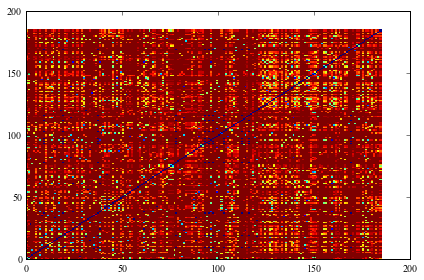

In [22]:
## need to integrate envorinmental data here
from skbio.diversity.beta import pw_distances

# subset
sub = phyto.iloc[:,0:-1]
# print sub.columns

# or exclude everything but dinos and diatoms
ids = sub.columns[2:]
# print ids
counts = sub.iloc[0:, 2:]
# print counts

stations = sub.index

# bc_dm = pw_distances(counts, ids = None, metric = "jaccard")

print len(pdist(counts, 'braycurtis')), len(counts)*len(stations)
plt.pcolor(squareform(pdist(counts, 'braycurtis')), vmin = 0, vmax = 1)



##looks like there may not be enough observations to get the distance matrix with only the species counts... problem with getting inverse matrix? ugh.

In [23]:
print len((phyto.iloc[:,4:-8]).columns), len(ids)



74 74


In [4]:
# fig0 = plt.figure(1, figsize=(16,14), dpi = 600)
# plt.pcolor(bc_dm.data, cmap = 'RdBu_r')
# plt.colorbar()
# plt.axis([0, len(bc_dm.data),0, len(bc_dm.data)])
# plt.show()

In [5]:
print type(stations)

<class 'pandas.indexes.base.Index'>


In [34]:
# cluster the stations by T/S data

bcc = clip(squareform(pdist(counts, 'braycurtis')),0,1)
# use this to label the phyto dendrogram

# lut = dict(zip(species.unique(), "rbg"))
# row_colors = species.map(lut)
# g = sns.clustermap(iris, row_colors=row_colors)

bc_data = pd.DataFrame(bcc, columns = stations).set_index(stations)

np.min(squareform(pdist(counts, 'braycurtis')))

nan

ValueError: Invalid method: cward

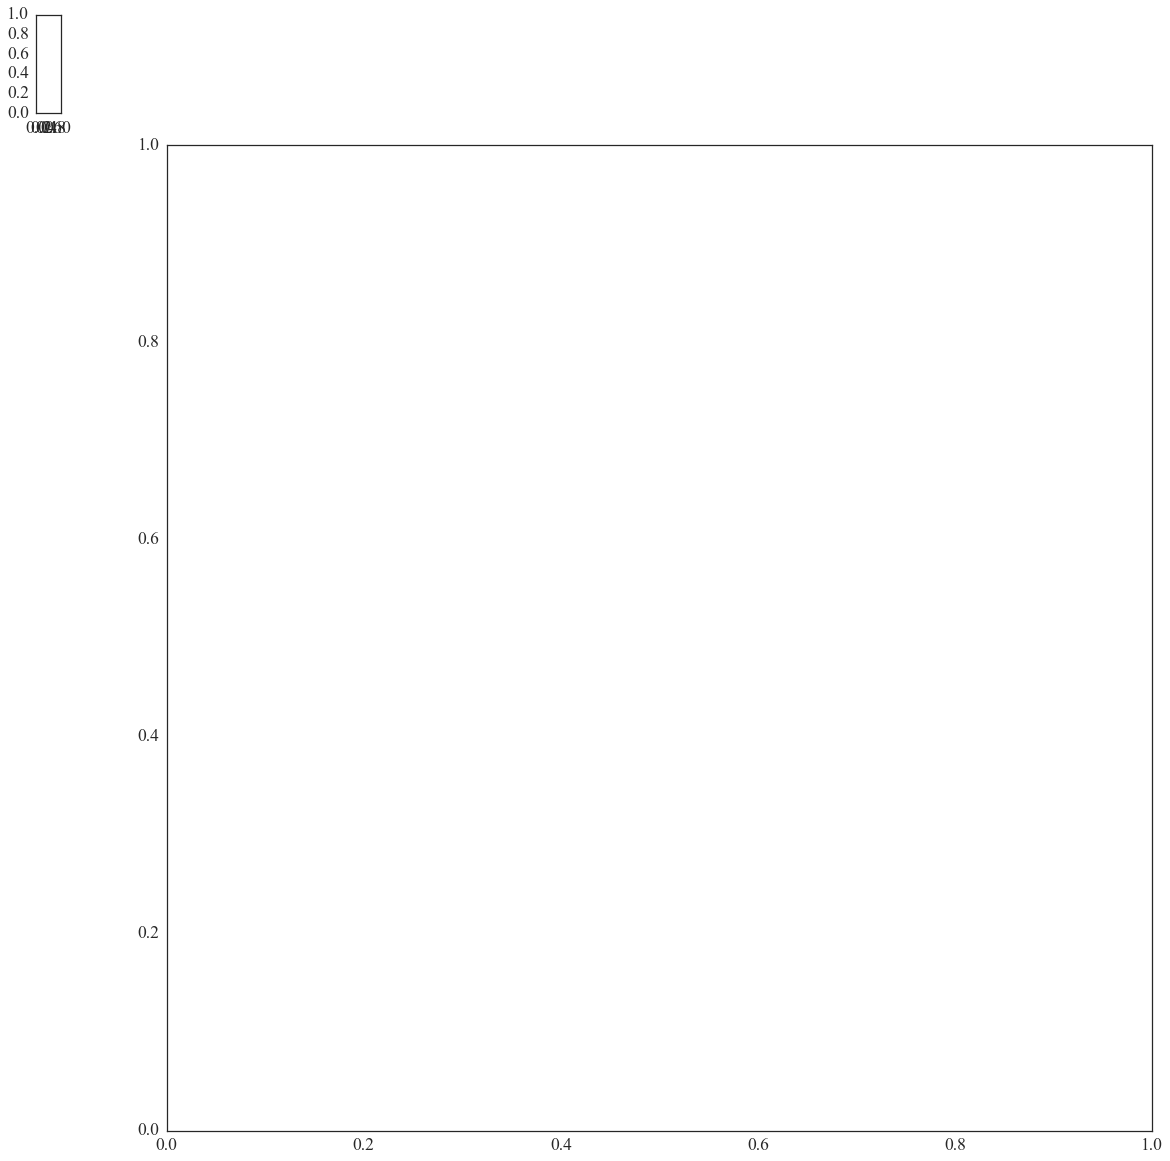

In [31]:
sns.set(font_scale=1.75)
sns.set_style("white",{'font.family': 'Times New Roman'},)

cm = sns.clustermap(bc_data,metric="euclidean", standard_scale=1, method="cward", cmap = 'RdYlBu',figsize=(20,20), cbar_kws={'label':'Bray-Curtis \n dissimilarity'})
ax = cm.ax_heatmap
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('Station', fontsize = 16)
ax.set_ylabel('Station', fontsize = 16)

# cm.savefig('../figures/phyto_clustermap_bc.png',dpi = 300)

/Users/archie/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


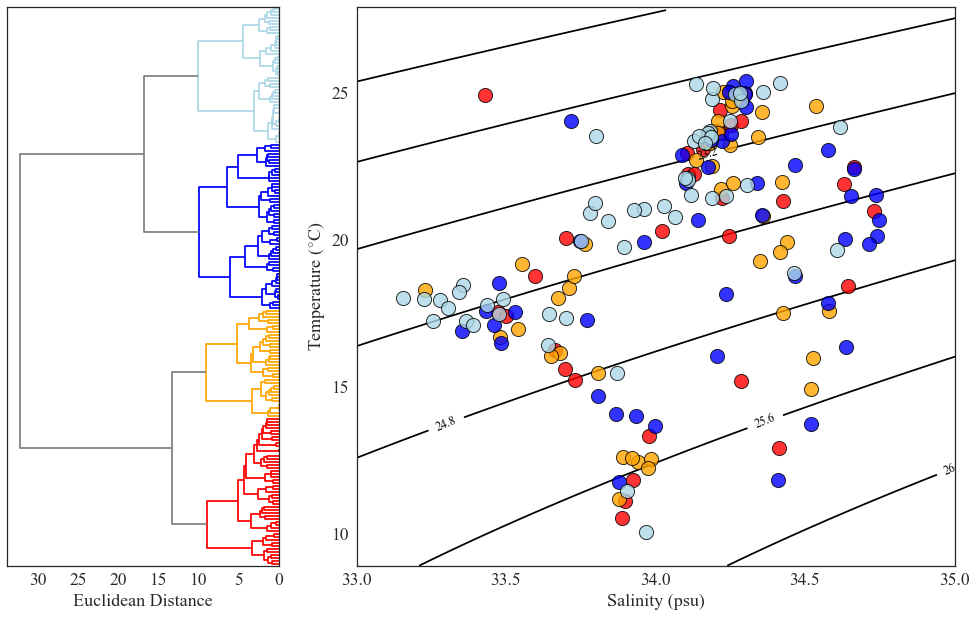

In [8]:
Z = hierarchy.linkage(bc_dm.data, 'ward')

from matplotlib import gridspec

fig1 = plt.figure(figsize=(14, 9), dpi = 300)
#set fontsize
nn = 18

gs = gridspec.GridSpec(1, 2, width_ratios=[1.25, 2.75]) 
ax1 = plt.subplot(gs[0])

# ax1.set_ylabel('Station - Depth',fontsize = nn)
ax1.set_xlabel('Euclidean Distance',fontsize = nn)
 
ax1.yaxis.set_ticks_position("right") # ticks and ticklabels 
ax1.yaxis.set_label_position("right") # axis label 

hierarchy.set_link_color_palette(['red','orange', 'blue', 'lightblue'])

hierarchy.dendrogram(
    Z,
    leaf_rotation=0.,  # rotates the x axis labels
    leaf_font_size=10.,  # font size for the x axis labels
    labels=bc_dm.ids,
    orientation="left", 
    color_threshold=12, 
    above_threshold_color='grey'
)

ax1.set_yticklabels([])

ax2 = plt.subplot(gs[1])

from scipy.cluster.hierarchy import fcluster
max_d = 12.

clusters = fcluster(Z, max_d, criterion='distance')
temp = pcoords[0:185]
temp['cluster'] = clusters

SS = np.arange(30,36,0.1)
TT = np.arange(9, 28, 0.1)

ss, tt = np.meshgrid(SS, TT, indexing='ij')

den = sw.density_enthalpy_48.sigma0(ss, tt)

ax2.set_xlim([33, 35])
ax2.set_ylim([9, 28])

cs = ax2.contour(ss, tt, den, [21.6, 22.4, 23.2, 24.0, 24.8, 25.6, 26.4], zorder = 0, colors = 'k', lw = 1)
ax2.clabel(cs, inline=1, fontsize=12, fmt='%3.1f')

cc = ['red','orange', 'blue', 'lightblue']
i = 0
for c in pd.unique(clusters):
    ctemp = temp[temp['cluster'] == c]
    cb = ax2.scatter(ctemp['S'].values, ctemp['theta'].values, s = 200,c= cc[i], lw = 1, alpha = 0.8)
    i += 1
ax2.set_xlabel('Salinity (psu)', fontsize = nn)
ax2.set_ylabel(r'Temperature ($^{\circ}$C)', fontsize = nn)

plt.show()
# fig1.savefig('../figures/phyto_dendro_bc_TS_nostns.png',dpi = 300)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                     185
number of groups                  4
test statistic              22.4754
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object


/Users/archie/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


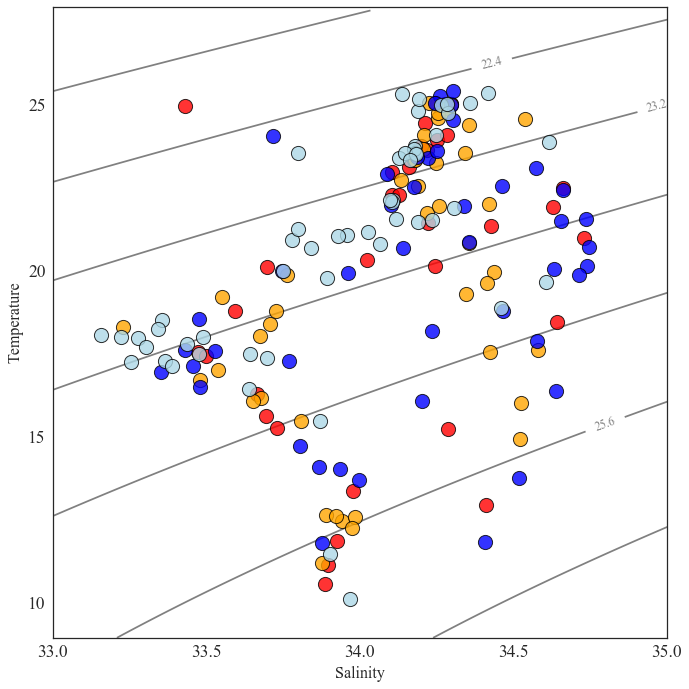

In [9]:
from scipy.cluster.hierarchy import fcluster
max_d = 12.

clusters = fcluster(Z, max_d, criterion='distance')
temp = pcoords[0:185]
temp['cluster'] = clusters

phyto['cluster'] = clusters


SS = np.arange(30,36,0.1)
TT = np.arange(9, 28, 0.1)

ss, tt = np.meshgrid(SS, TT, indexing='ij')

den = sw.density_enthalpy_48.sigma0(ss, tt)


fig2 = plt.figure(figsize = (10,10))
plt.xlim([33, 35])
plt.ylim([9, 28])

cs = plt.contour(ss, tt, den, [21.6, 22.4, 23.2, 24.0, 24.8, 25.6, 26.4], zorder = 0, colors = 'grey', lw =2)
plt.clabel(cs, inline=1, fontsize=12, fmt='%3.1f')

cc = ['red','orange', 'blue', 'lightblue']
i = 0
for c in pd.unique(clusters):
    ctemp = temp[temp['cluster'] == c]
    cb = plt.scatter(ctemp['S'].values, ctemp['theta'].values, s = 200,c= cc[i], lw = 1, alpha = 0.8)
    i += 1
plt.xlabel('Salinity', fontsize = 16)
plt.ylabel('Temperature', fontsize = 16)
# cbar = plt.colorbar(cb, ticks = [])

# cbar.set_label('Clusters', labelpad = 10)


from skbio.stats.distance import permanova

print permanova(bc_dm, clusters, column=None, permutations=999)

In [24]:
from skbio.stats.ordination import RDA

# X = data[['depth (m)','S', 'sigma_t', 'theta', 'SiO2 (uM)', 'NO3 (uM)','NH4(uM)','PO4 (uM)']].dropna()
X = data[['depth (m)','S', 'theta', 'NO3 (uM)' ]].dropna()#, 'SiO2 (uM)', 'NO3 (uM)']].dropna()

phyto = phyto.loc[X.index, :]

Y = phyto.iloc[:, 4:-8]

print len(Y), len(X.index)


e_vars = X.columns

thing = RDA(Y, X, stations, e_vars, scale_Y=True).scores(1)

print thing
print np.max((thing.proportion_explained)*100)


183 183
Ordination results:
	Eigvals: 75
	Proportion explained: 75
	Species: 74x75
	Site: 183x75
	Biplot: 4x4
	Site constraints: 183x75
	Species IDs: 'depth (m)', 'S', 'theta', 'NO3 (uM)'
	Site IDs: 'A1-0', 'A1-25', 'A1-48', 'A1-75', 'A1-150', 'A2-0', 'A2-25', 'A2-50', 'A2-75', ...
2.69475224305


In [11]:
# for n in range(1,np.max(clusters+1)):
#     print 'mean values for cluster ', n
#     print temp[temp['cluster']==n].describe()
#     print '--------'

In [12]:
len(phyto)

183

In [26]:

for n in range(1,np.max(clusters+1)):
    print 'dominant phyto in cluster ', n
    
    tmp = Y[phyto['cluster']==n].sum()
    print tmp.sort_values(axis=0, ascending=False)[0:5]/np.sum(tmp)*100
    print '--------'

dominant phyto in cluster  1
Thalassiosiraceae             32.078240
Nitzschia spp.                14.645477
Aulacoseira ambigua            8.875306
Thalassiosira spp.             5.941320
Rhizosolenia stolterfothii     4.889976
dtype: float64
--------
dominant phyto in cluster  2
Peridiniales            25.987879
Nitzschia spp.           8.339394
Aulacoseira distans      6.981818
Prorocentrum minimum     6.375758
Gymnodiniales            5.066667
dtype: float64
--------
dominant phyto in cluster  3
Peridiniales                   54.949628
Thalassiosiraceae              18.089376
Nitzschia spp.                  4.289678
Prorocentrum sp.                3.178537
Thalassionema nitzschioides     2.841827
dtype: float64
--------
dominant phyto in cluster  4
Peridiniales            69.942001
Nitzschia spp.           3.797238
Thalassiosira spp.       2.645062
Aulacoseira distans      2.600848
Prorocentrum minimum     2.600848
dtype: float64
--------


In [28]:

for n in range(1,np.max(clusters+1)):
    print 'cluster', n
    
    tmp = Y[phyto['cluster']==n]
    tmp['richness'] = tmp.astype(bool).sum(axis=1)
    
    print tmp['richness'].mean(), '+/-', tmp['richness'].std()
                   


transect 1
3.125 +/- 1.6193642041
transect 2
4.22222222222 +/- 2.58690229658
transect 3
5.09259259259 +/- 1.75121002392
transect 4
3.31111111111 +/- 1.53478192443


/Users/archie/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
